In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from ast import literal_eval

### Functions

In [56]:
def dict_to_list(dict_str):
    """
    Parses a json dictionary into a list
    """
    try:
        genre_dict = literal_eval(dict_str)
        return list(genre_dict.values())
    except (ValueError, SyntaxError):
        return None
    
def str_to_list(str):
    """
    Parses a string which includes values seperated by commas and returns a list
    """
    try:
        return str.split(", ")
    except AttributeError:
        return None

def get_capitalized_first_letter(text):
    """
    Splits the string into words by ' '. Capitalizes the first
    letter of every word.
    """
    return ' '.join(word.capitalize() for word in text.split())

# Countries

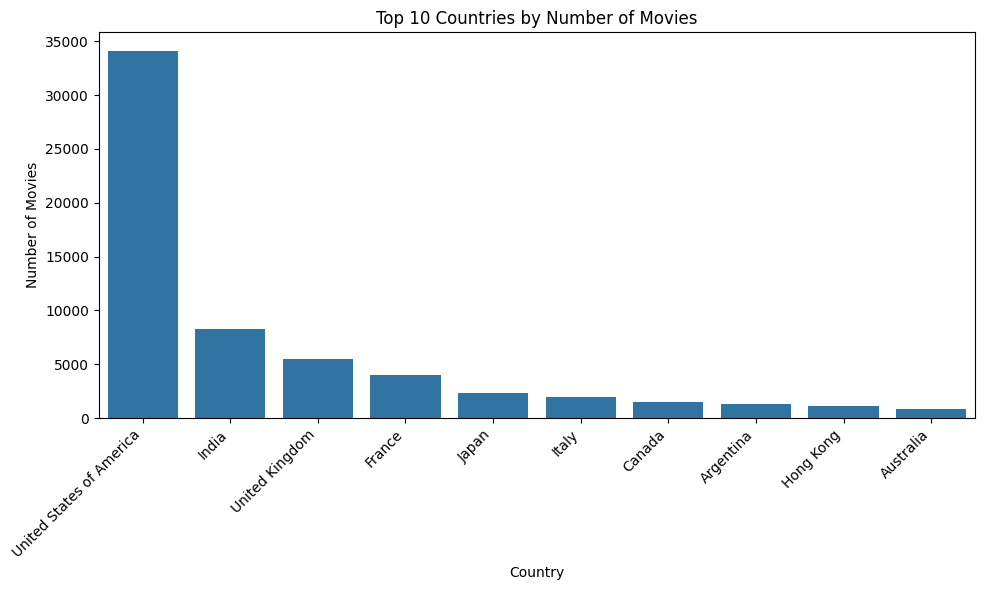

In [40]:
# Load the data
PATH = 'cmu/'
movies_metadata = pd.read_csv(PATH + 'movie.metadata.tsv', sep='\t', header=None)
movies_metadata.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']

# Drop rows with empty or NaN values in the 'Movie countries' column
movies_metadata = movies_metadata[movies_metadata['Movie countries'] != '{}']

# Extract just the country names
movies_metadata['Movie countries'] = movies_metadata['Movie countries'].apply(lambda x: list(eval(x).values())[0])

# Calculate the number of movies per country
country_counts = movies_metadata['Movie countries'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Number of Movies")
plt.title("Top 10 Countries by Number of Movies")
plt.tight_layout()
plt.show()



# Sentiment Summary Analysis

In [ ]:
# Load the datasets
PATH = 'cmu/'
movies = pd.read_csv(PATH + 'movie.metadata.tsv', sep='\t', header=None)
movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']

plot_summaries = pd.read_csv(PATH + 'plot_summaries.txt', sep='\t', header=None)
plot_summaries.columns = ['Wikipedia movie ID', 'Plot']

# Merge datasets on 'Wikipedia movie ID'
movies = movies.merge(plot_summaries, on='Wikipedia movie ID', how='inner')
movies['Movie box office revenue'] = pd.to_numeric(movies['Movie box office revenue'], errors='coerce')
movies = movies.dropna(subset=['Movie box office revenue', 'Plot'])


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# TF-IDF vectorization for plot summaries
vectorizer = TfidfVectorizer(max_features=500)
plot_tfidf = vectorizer.fit_transform(movies['Plot'])

# Add sentiment score as a feature
movies['sentiment'] = movies['Plot'].apply(lambda plot: TextBlob(plot).sentiment.polarity)


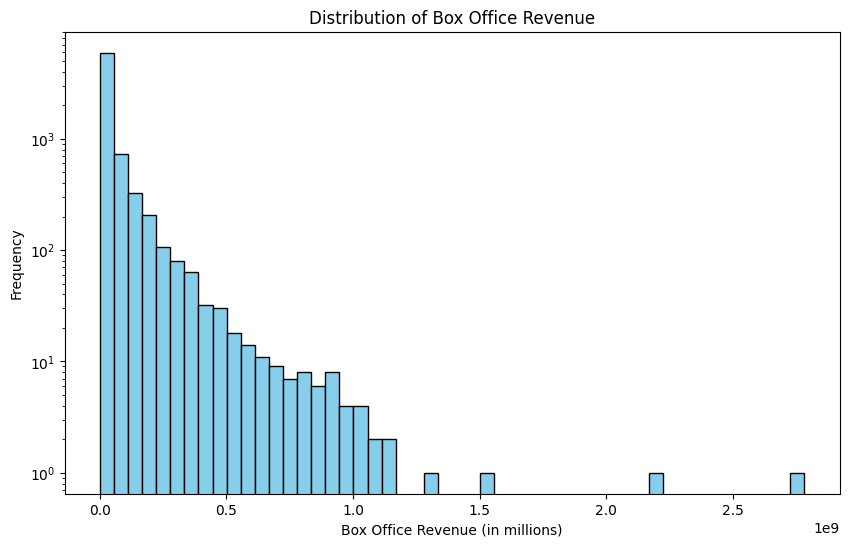

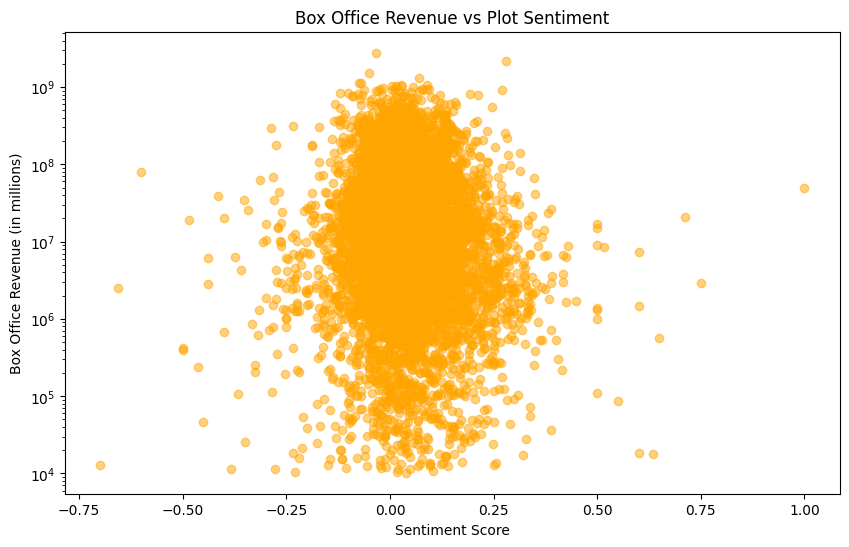

In [43]:
# Extract year from release date
movies['release_year'] = pd.to_datetime(movies['Movie release date'], errors='coerce').dt.year

# Extract genres as separate dummy variables
movies['Extracted Genres'] = movies['Movie genres'].apply(lambda x: [g.split(':')[-1] for g in x.strip('{}').split(', ')])
genres = movies['Extracted Genres'].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum()
movies = pd.concat([movies, genres], axis=1)

# Histogram of box office revenue
plt.figure(figsize=(10, 6))
plt.hist(movies['Movie box office revenue'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Box Office Revenue')
plt.xlabel('Box Office Revenue (in millions)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale if revenue is highly skewed
plt.show()


# Scatter plot of sentiment vs revenue
plt.figure(figsize=(10, 6))
plt.scatter(movies['sentiment'], movies['Movie box office revenue'], alpha=0.5, color='orange')
plt.title('Box Office Revenue vs Plot Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Box Office Revenue (in millions)')
plt.yscale('log')
plt.show()


C:\Users\liess\AppData\Local\Temp\ipykernel_112392\611460565.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_by_bucket = movies.groupby('Readability Bucket')['Movie box office revenue'].mean()


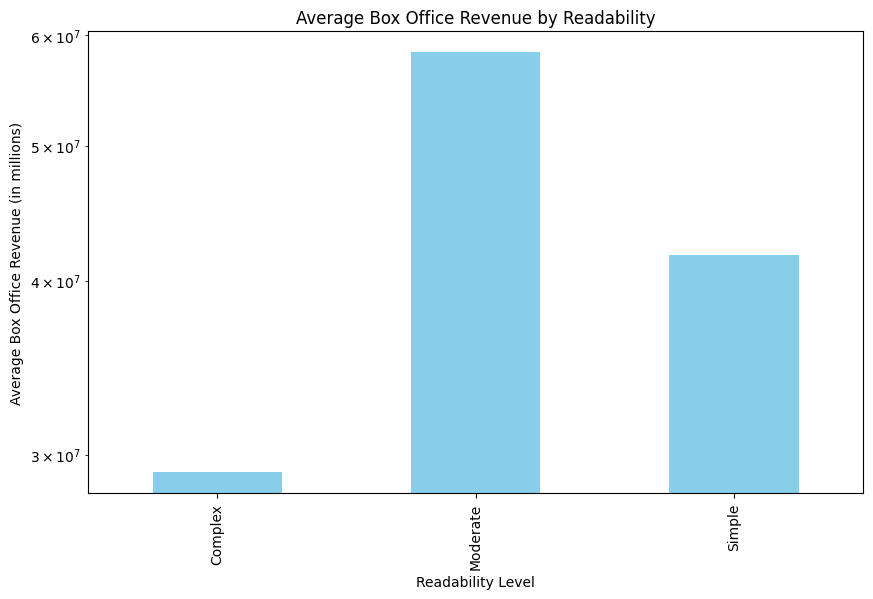

In [44]:
# 3

import textstat

# Calculate Flesch Reading Ease Score
movies['Readability'] = movies['Plot'].apply(textstat.flesch_reading_ease)

# Create buckets for readability scores
movies['Readability Bucket'] = pd.cut(movies['Readability'], bins=[0, 50, 70, 100], labels=['Complex', 'Moderate', 'Simple'])

# Calculate average revenue and rating by readability bucket
avg_revenue_by_bucket = movies.groupby('Readability Bucket')['Movie box office revenue'].mean()
# avg_rating_by_bucket = movies.groupby('Readability Bucket')['Rating'].mean()

# Plot average revenue by readability bucket
plt.figure(figsize=(10, 6))
avg_revenue_by_bucket.plot(kind='bar', color='skyblue')
plt.title('Average Box Office Revenue by Readability')
plt.xlabel('Readability Level')
plt.ylabel('Average Box Office Revenue (in millions)')
plt.yscale('log')
plt.show()

# Plot average rating by readability bucket
#plt.figure(figsize=(10, 6))
#avg_rating_by_bucket.plot(kind='bar', color='lightcoral')
#plt.title('Average Rating by Readability')
#plt.xlabel('Readability Level')
#plt.ylabel('Average Rating')
#plt.show()


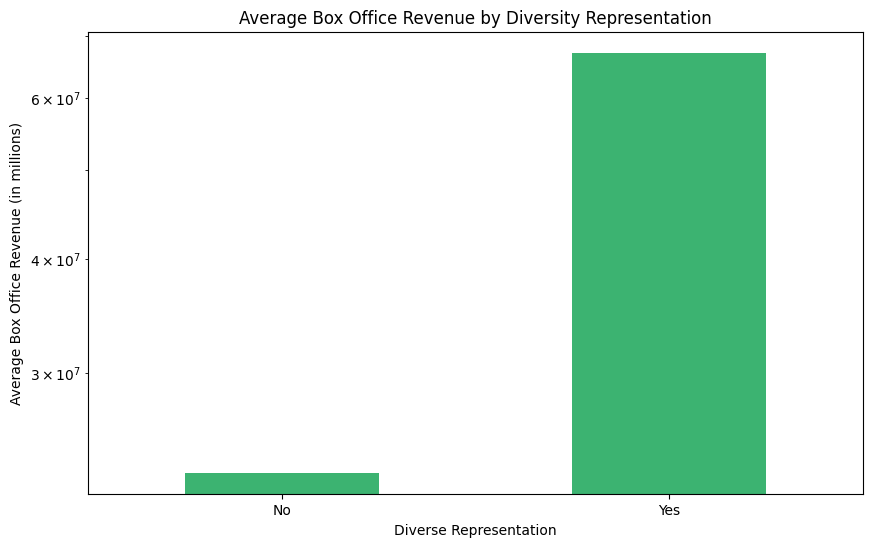

In [ ]:
# 7
import spacy

%pip install spacy
%python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')

# NER function to identify diversity elements
def extract_entities(text):
    doc = nlp(text)
    entities = {'characters': [], 'locations': [], 'other_entities': []}
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entities['characters'].append(ent.text)
        elif ent.label_ == "GPE":
            entities['locations'].append(ent.text)
        else:
            entities['other_entities'].append((ent.text, ent.label_))
    return entities

# Apply NER
movies['Entities'] = movies['Plot'].apply(extract_entities)

# Flag movies with diverse characters and locations based on entity count
movies['Diverse Representation'] = movies['Entities'].apply(lambda x: len(x['characters']) > 3 and len(x['locations']) > 1)

# Calculate average revenue and rating for diverse vs non-diverse representation
avg_revenue_by_diversity = movies.groupby('Diverse Representation')['Movie box office revenue'].mean()
#avg_rating_by_diversity = movies.groupby('Diverse Representation')['Rating'].mean()

# Plot average revenue by diversity representation
plt.figure(figsize=(10, 6))
avg_revenue_by_diversity.plot(kind='bar', color='mediumseagreen')
plt.title('Average Box Office Revenue by Diversity Representation')
plt.xlabel('Diverse Representation')
plt.ylabel('Average Box Office Revenue (in millions)')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.yscale('log')
plt.show()

# Plot average rating by diversity representation
#plt.figure(figsize=(10, 6))
#avg_rating_by_diversity.plot(kind='bar', color='salmon')
#plt.title('Average Rating by Diversity Representation')
#plt.xlabel('Diverse Representation')
#plt.ylabel('Average Rating')
#plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
#plt.show()



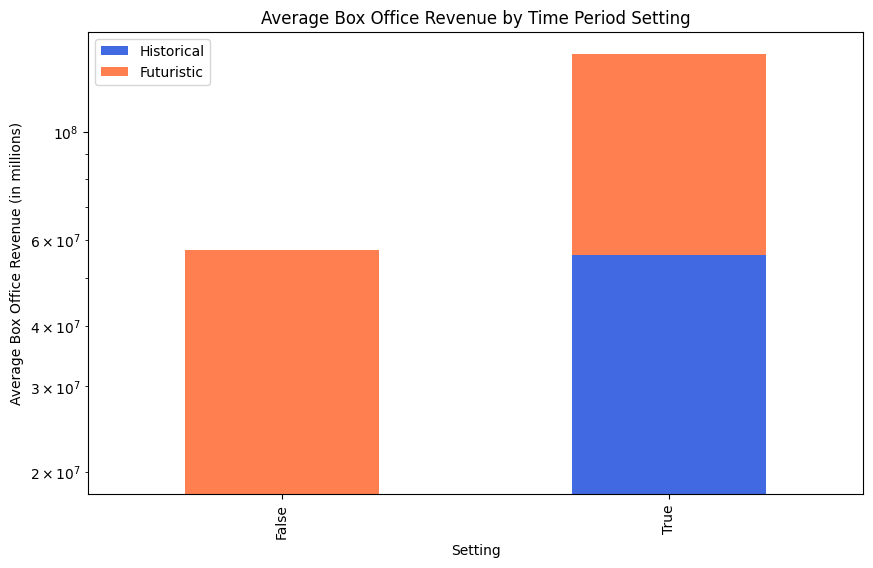

In [29]:
# Define keywords for historical and futuristic contexts
time_periods = {'historical': ['king', 'war', 'ancient', 'medieval', 'empire', '19th century', 'world war'],
                'futuristic': ['alien', 'space', 'future', 'robot', 'cyber', 'dystopia']}

# Detect time period keywords
def detect_time_period(text, keywords):
    periods = {}
    for key, words in keywords.items():
        periods[key] = any(word in text.lower() for word in words)
    return periods

# Apply detection
movies['Time Period'] = movies['Plot'].apply(lambda x: detect_time_period(x, time_periods))

# Flag movies with historical or futuristic settings based on keywords
movies['Historical'] = movies['Time Period'].apply(lambda x: x['historical'])
movies['Futuristic'] = movies['Time Period'].apply(lambda x: x['futuristic'])

# Calculate average revenue and rating for historical and futuristic movies
avg_revenue_by_time_period = movies.groupby(['Historical', 'Futuristic'])['Movie box office revenue'].mean()
#avg_rating_by_time_period = movies.groupby(['Historical', 'Futuristic'])['Rating'].mean()

# Plot average revenue by time period
avg_revenue_by_time_period.unstack().plot(kind='bar', stacked=True, color=['royalblue', 'coral'], figsize=(10, 6))
plt.title('Average Box Office Revenue by Time Period Setting')
plt.xlabel('Setting')
plt.ylabel('Average Box Office Revenue (in millions)')
plt.legend(['Historical', 'Futuristic'])
plt.yscale('log')
plt.show()

# Plot average rating by time period
#avg_rating_by_time_period.unstack().plot(kind='bar', stacked=True, color=['royalblue', 'coral'], figsize=(10, 6))
#plt.title('Average Rating by Time Period Setting')
#plt.xlabel('Setting')
#plt.ylabel('Average Rating')
#plt.legend(['Historical', 'Futuristic'])
#plt.show()


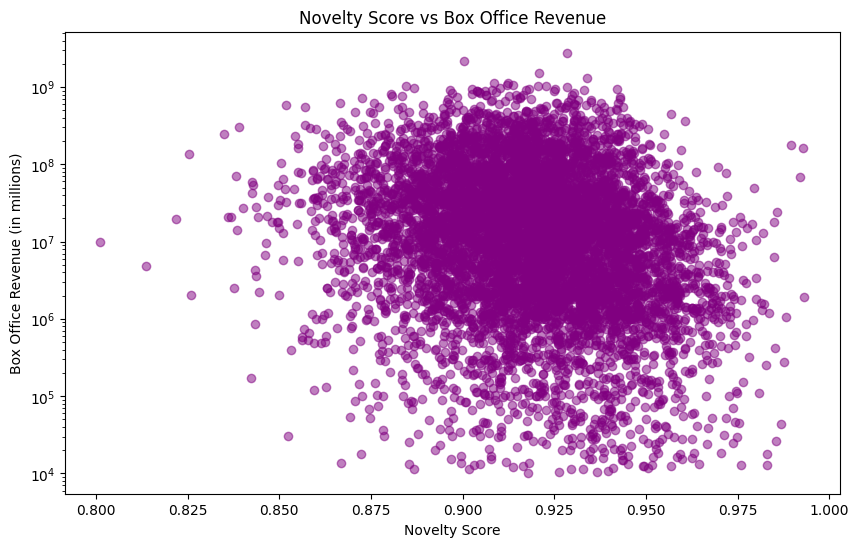

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize plot summaries
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(movies['Plot'])

# Calculate cosine similarity and measure uniqueness
cosine_similarities = cosine_similarity(tfidf_matrix)
average_similarity = cosine_similarities.mean(axis=1)  # Lower values indicate higher uniqueness
movies['Novelty Score'] = 1 - average_similarity  # Novelty as (1 - avg similarity)

# Scatter plot of novelty score vs box office revenue
plt.figure(figsize=(10, 6))
plt.scatter(movies['Novelty Score'], movies['Movie box office revenue'], alpha=0.5, color='purple')
plt.title('Novelty Score vs Box Office Revenue')
plt.xlabel('Novelty Score')
plt.ylabel('Box Office Revenue (in millions)')
plt.yscale('log')
plt.show()

# Scatter plot of novelty score vs rating
#plt.figure(figsize=(10, 6))
#plt.scatter(movies['Novelty Score'], movies['Rating'], alpha=0.5, color='teal')
#plt.title('Novelty Score vs Rating')
#plt.xlabel('Novelty Score')
#plt.ylabel('Rating')
#plt.show()


# Actor Gender

In [57]:
PATH = 'cmu/'

movies = pd.read_csv(PATH + 'movie.metadata.tsv', sep='\t', header=None)
movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movies['Extracted Genres'] = movies['Movie genres'].apply(dict_to_list)
movies['Extracted Languages'] = movies['Movie languages'].apply(dict_to_list)
movies['Movie box office revenue'] = pd.to_numeric(movies['Movie box office revenue'], errors='coerce')
movies = movies.dropna(subset=['Movie name', 'Movie box office revenue', 'Extracted Genres'])

characters = pd.read_csv(PATH + 'character.metadata.tsv', sep='\t', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date', 'Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']
characters = characters.dropna(subset=['Actor gender'])

Actor gender
F    6.557150e+07
M    7.391787e+07
Name: Movie box office revenue, dtype: float64


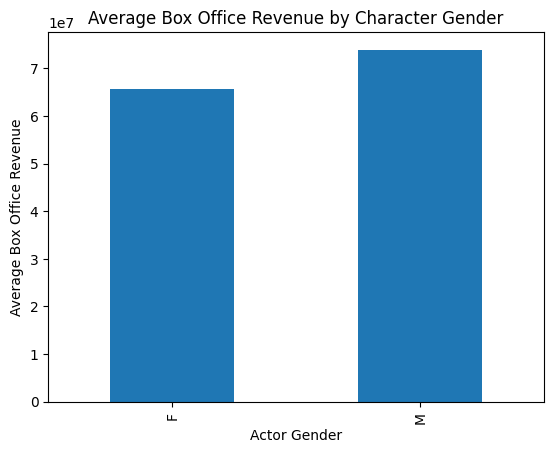

In [58]:
# Merge movies and characters data on 'Wikipedia movie ID'
merged_data = pd.merge(movies, characters, on='Wikipedia movie ID')

# Group by Actor gender and calculate mean box office revenue
gender_box_office = merged_data.groupby('Actor gender')['Movie box office revenue'].mean()

# Display the correlation results
print(gender_box_office)

# Plot
gender_box_office.plot(kind='bar')
plt.title('Average Box Office Revenue by Character Gender')
plt.xlabel('Actor Gender')
plt.ylabel('Average Box Office Revenue')
plt.show()
